一维瞬态扩散方程为：

$$
\frac{\partial \phi}{\partial t} = \frac{\partial}{\partial x}\left(\Gamma \frac{\partial \phi}{\partial x}\right) + S
$$

### 1. 控制体积积分
首先，我们考虑一个控制体积（或称为网格单元），其边界位于 $x_{i-1/2}$ 和 $x_{i+1/2}$ 之间，中心点在 $x_i$。控制体积的宽度为 $\Delta x = x_{i+1/2} - x_{i-1/2}$。

我们将方程在整个控制体积内进行积分：

$$
\int_{x_{i-1/2}}^{x_{i+1/2}} \frac{\partial \phi}{\partial t} dx = \int_{x_{i-1/2}}^{x_{i+1/2}} \frac{\partial}{\partial x}\left(\Gamma \frac{\partial \phi}{\partial x}\right) dx + \int_{x_{i-1/2}}^{x_{i+1/2}} S dx
$$

### 2. 时间项离散
左边的时间项积分可以写成：

$$
\int_{x_{i-1/2}}^{x_{i+1/2}} \frac{\partial \phi}{\partial t} dx = \frac{d}{dt} \int_{x_{i-1/2}}^{x_{i+1/2}} \phi dx
$$

假设 $\phi$ 在控制体积内是均匀分布的，那么可以近似为：

$$
\frac{d}{dt} \left( \phi_i \Delta x \right) = \Delta x \frac{d\phi_i}{dt}
$$

在时间步长上采用欧拉向前差分：

$$
\Delta x \frac{\phi_i^{n+1} - \phi_i^n}{\Delta t}
$$

这里 $n$ 表示当前时间步，$n+1$ 表示下一个时间步。

### 3. 扩散项离散
右边的第一项扩散通量可以应用高斯定理：

$$
\int_{x_{i-1/2}}^{x_{i+1/2}} \frac{\partial}{\partial x}\left(\Gamma \frac{\partial \phi}{\partial x}\right) dx = \left[ \Gamma \frac{\partial \phi}{\partial x} \right]_{x_{i-1/2}}^{x_{i+1/2}}
$$

这表示通过控制体积边界的通量差。我们需要计算这两个面上的通量 $\Gamma \frac{\partial \phi}{\partial x}$。

#### a. 面上的梯度计算
在面 $x_{i+1/2}$ 上，梯度可以使用相邻两个节点的值来近似：

$$
\left( \frac{\partial \phi}{\partial x} \right)_{i+1/2} \approx \frac{\phi_{i+1} - \phi_i}{\Delta x}
$$

类似地，在面 $x_{i-1/2}$ 上：

$$
\left( \frac{\partial \phi}{\partial x} \right)_{i-1/2} \approx \frac{\phi_i - \phi_{i-1}}{\Delta x}
$$

如果 $\Gamma$ 是常数或者已知的，则可以直接代入。否则，需要对面上的 $\Gamma$ 值进行插值，例如算术平均：

$$
\Gamma_{i+1/2} = \frac{\Gamma_i + \Gamma_{i+1}}{2}, \quad \Gamma_{i-1/2} = \frac{\Gamma_{i-1} + \Gamma_i}{2}
$$

因此扩散项离散形式为：

$$
\left[ \Gamma \frac{\partial \phi}{\partial x} \right]_{x_{i-1/2}}^{x_{i+1/2}} \approx \left( \Gamma \frac{\partial \phi}{\partial x} \right)_{i+1/2} - \left( \Gamma \frac{\partial \phi}{\partial x} \right)_{i-1/2}
$$

$$
= \Gamma_{i+1/2} \frac{\phi_{i+1} - \phi_i}{\Delta x} - \Gamma_{i-1/2} \frac{\phi_i - \phi_{i-1}}{\Delta x}
$$

### 4. 源项离散
源项 $S$ 积分可以近似为：

$$
\int_{x_{i-1/2}}^{x_{i+1/2}} S dx \approx S_i \Delta x
$$

### 5. 完整离散方程
将所有部分组合起来得到最终的离散方程：

$$
\Delta x \frac{\phi_i^{n+1} - \phi_i^n}{\Delta t} = \frac{1}{\Delta x} \left[ \Gamma_{i+1/2} (\phi_{i+1} - \phi_i) - \Gamma_{i-1/2} (\phi_i - \phi_{i-1}) \right] + S_i \Delta x
$$

整理后可得：

$$
\frac{\phi_i^{n+1} - \phi_i^n}{\Delta t} = \frac{1}{(\Delta x)^2} \left[ \Gamma_{i+1/2} (\phi_{i+1} - \phi_i) - \Gamma_{i-1/2} (\phi_i - \phi_{i-1}) \right] + S_i
$$

这就是采用有限体积法对一维瞬态扩散方程进行离散后的形式。该方程可用于数值求解 $\phi$ 在不同时间和空间位置的值。

r = 0.0025000000000000005


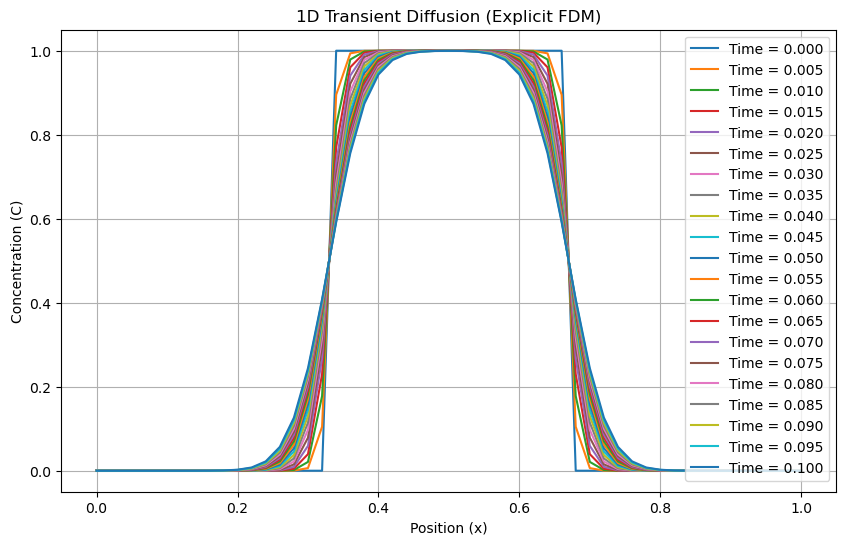

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# --- 参数设定 ---
L = 1.0  # 空间长度
T = 0.1  # 模拟总时间
D = 0.01 # 扩散系数
S = 0.0  # 源项 (为简化，这里设为0)

# --- 离散化参数 ---
nx = 51   # 空间网格点数 (包含边界)
dx = L / (nx - 1) # 空间步长

dt = 0.0001 # 时间步长 (需要满足稳定性条件 r <= 0.5)
r = D * dt / (dx**2)
print(f"r = {r}")
if r > 0.5:
    print("警告：r > 0.5，显式格式可能不稳定！")

nt = int(T / dt) # 时间步数

# --- 初始化 ---
C = np.zeros(nx)
# 初始条件：中间区域浓度高，两端为0
C[int(nx/3) : int(2*nx/3)] = 1.0
C_new = np.zeros(nx)

# --- 边界条件 ---
# Dirichlet 边界条件 (两端固定为0)
C_left = 0.0
C_right = 0.0

# --- 存储结果用于绘图 ---
x = np.linspace(0, L, nx)
C_history = [C.copy()]
time_points = [0]

# --- 迭代求解 ---
for j in range(nt):
    # 施加边界条件
    C_new[0] = C_left
    C_new[nx-1] = C_right

    # 计算内部节点
    for i in range(1, nx - 1):
        C_new[i] = (1 - 2*r) * C[i] + r * (C[i+1] + C[i-1]) + S * dt

    C = C_new.copy() # 更新浓度分布

    if (j + 1) % 50 == 0 or j == nt - 1: # 每隔一段时间存储结果
        C_history.append(C.copy())
        time_points.append((j + 1) * dt)

# --- 绘图 ---
plt.figure(figsize=(10, 6))
for k, C_snap in enumerate(C_history):
    plt.plot(x, C_snap, label=f'Time = {time_points[k]:.3f}')

plt.xlabel("Position (x)")
plt.ylabel("Concentration (C)")
plt.title("1D Transient Diffusion (Explicit FDM)")
plt.legend()
plt.grid(True)
plt.show()